## License Information
---------

This file is part of `hvsrpy`, a Python module for horizontal-to-vertical spectral ratio processing.

    Copyright (C) 2019 Joseph P. Vantassel (jvantassel@utexas.edu)

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https: //www.gnu.org/licenses/>.
    
## About _hvsrpy_
---------------

`hvsrpy` is a Python module for performing horizontal-to-vertical spectral ratio (H/V) calculations.
This notebook and `hvsrpy` were developed by Joseph P. Vantassel with contributions from Dana Brannon under the supervision of Professor Brady R. Cox at the University of Texas at Austin.
The automated frequency-domain rejection algorithm implemented in `hvsrpy` was developed by Tianjian Cheng under the supervision of Professor Brady R. Cox at the Univesity of Texas at Austin and detailed in Cox et al. (in review). 
This notebook is intended as a simplified interface to `hvsrpy` to allow a user to perform H/V processing without the need to write any additional code.

## Getting Started
-----------------
1. Follow the instructions in _README.md_ to install _hvsrpy_ and its dependencies. __(~30 minutes)__
2. Try analyzing the four provided example files. The names of these files have been written and commented out in the section _Time Domain Settings_ for your conveinience. __(~30 minutes)__
3. Try one of your own _miniseed_ files and confirm that the result from _hvsrpy_ matches that of Geopsy. If you get an error related to the _miniseed_ file this likely means it does
not conform to the _SEED_ standard (refer to _hvsrpy_ documentation for details), if the problem persists please send a copy of the file along with the error message to (jvantassel@utexas.edu). __(~15 minutes)__

Happy Processing!

In [1]:
import hvsrpy
import numpy as np
import matplotlib.pyplot as plt
import time

## Time Domain Settings
-----------------------

In [2]:
# Input file name (may be relative or a full path).
file_name = "UT.STN11.A2_C50.miniseed"
# file_name = "UT.STN11.A2_C150.miniseed"
# file_name = "UT.STN12.A2_C50.miniseed"
# file_name = "UT.STN12.A2_C150.miniseed"

# Window length in seconds. In general low frequency peaks require longer window lengths. See SESAME guidelines for specific window length recommendations.
windowlength = 60

# Boolean to control whether Butterworth filter is applied. Geopsy does not apply a bandpass filter.
filter_bool = False          
# Low-cut frequency for bandpass filter.
flow = 0.1                   
# High-cut frequency for bandpass filter.
fhigh = 45                   
# Filter order.
forder = 5

# Width of cosine taper {0. - 1.}. Geopsy default of 0.05 is equal to 0.1 -> 0.1 is recommended
width = 0.1

## Frequency Domain Settings
--------------------------

In [3]:
# Konno and Ohmachi smoothing constant. 40 is recommended.
bandwidth = 40

# Minimum frequency after resampling
minf = 0.3          
# Maximum frequency after resampling
maxf = 40
# Number of frequencies after resampling
nf = 2048
# Type of resampling {'log', 'linear'}
res_type = 'log'

## H/V Settings
--------------

In [4]:
# Method for combining horizontal components {"squared-average", "geometric-mean"}. Geopsy default is "squared-average" -> "geometric-mean" is recommended.
method = 'geometric-mean'

# Boolean to control whether frequency domain rejection proposed by Cox et al. (in review) is applied. Geopsy does not offer the ability for automatic rejection in the frequency domain.
rejection_bool = True
# Number of standard deviations to consider during rejection. Smaller values will reject more windows -> 2 is recommended.
n = 2
# Maximum number of iterations to perform for rejection -> 50 is recommended.
n_iteration = 50

# Distribution of f0 {"log-normal", "normal"}. Geopsy default "normal" -> "log-normal" is recommended.
distribution_f0 = "log-normal"
# Distribution of mean curve {"log-normal", "normal"}. Geopsy default "log-normal" -> "log-normal" is recommended.
distribution_mc = "log-normal"

## Perform Calculation
--------------

Elapsed Time: 1.2070279121398926 seconds
Number of iterations to convergence is 2 of 50 allowed.


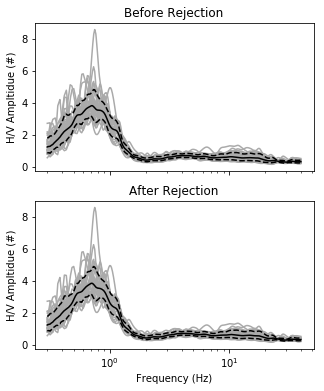

In [5]:
start = time.time()
sensor = hvsrpy.Sensor3c.from_mseed(file_name)
bp_filter = {"flag":filter_bool, "flow":flow, "fhigh":fhigh, "order":forder}
resampling = {"minf":minf, "maxf":maxf, "nf":nf, "res_type":res_type}
hv = sensor.hv(windowlength, bp_filter, width, bandwidth, resampling, method)
end = time.time()
print(f"Elapsed Time: {(end-start)} seconds")

if rejection_bool:
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(5,6))
    plt.subplots_adjust(hspace=0.2)
    ax = axs[0]
else:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3))

for amp in hv.amp:
    ax.plot(hv.frq, amp, color='#aaaaaa')
ax.plot(hv.frq, hv.mean_curve(distribution_mc), color='k')
ax.plot(hv.frq, hv.nstd_curve(-1, distribution_mc), color='k', linestyle='--')
ax.plot(hv.frq, hv.nstd_curve(+1, distribution_mc), color='k', linestyle='--')
if not rejection_bool:
    ax.set_xlabel("Frequency (Hz)")
else:
    ax.set_title("Before Rejection")
ax.set_ylabel("H/V Ampltidue (#)")
ax.set_xscale('log')

if rejection_bool:
    ax=axs[1]
    c_iter = hv.reject_windows(n, max_iterations=n_iteration, distribution_f0=distribution_f0, distribution_mc=distribution_mc)
    print(f"Number of iterations to convergence is {c_iter} of {n_iteration} allowed.")
    for amp in hv.amp[hv.valid_window_indices]:
        plt.plot(hv.frq, amp, color='#aaaaaa')
    ax.set_title("After Rejection")
    ax.plot(hv.frq, hv.mean_curve(distribution_mc), color='k')
    ax.plot(hv.frq, hv.nstd_curve(-1, distribution_mc), color='k', linestyle='--')
    ax.plot(hv.frq, hv.nstd_curve(+1, distribution_mc), color='k', linestyle='--')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("H/V Ampltidue (#)")
    plt.xscale('log')
plt.show()

In [6]:
# TODO (jpv): Implement new plotting and be sure to print important values somewhere

## Save Figure to File
-----------------

In [7]:
figure_name_out = "example_hvsr_figure.png"

if rejection_bool:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3))
    for amp in hv.amp[hv.valid_window_indices]:
        plt.plot(hv.frq, amp, color='#aaaaaa')
    ax.plot(hv.frq, hv.mean_curve(distribution_mc), color='k')
    ax.plot(hv.frq, hv.nstd_curve(-1, distribution_mc), color='k', linestyle='--')
    ax.plot(hv.frq, hv.nstd_curve(+1, distribution_mc), color='k', linestyle='--')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("H/V Ampltidue (#)")
    plt.xscale('log')
fig.savefig(figure_name_out, dpi=300, bbox_inches='tight')
plt.close()
print("Figure saved successfully!")

Figure saved successfully!


## Save Results to _Geopsy_-Style File
---------------

In [8]:
file_name_out = "example_output.hv"

hv.to_file_like_geopsy(file_name_out, distribution_f0, distribution_mc)
print("Results saved successfully!")

Results saved successfully!
